<p style="font-size:35px; text-align:center; font-weight:bold">CMAAS run SOM clustering method</p>
<p style="font-size:17px; text-align:left">Ina Storch 06-11-2023 </p>
<p style="font-size:17px; text-align:left">Note: This notebook is designed to run SOM using preprocessed data gained from the datacube from: Lawley et al., 2021. </p>
<p style="font-size:17px; text-align:left">Reference: Lawley, C.J.M., McCafferty, A.E., Graham, G.E., Gadd, M.G., Huston, D.L., Kelley, K.D., Paradis, S., Peter, J.M., and Czarnota, K., 2021. Datasets to support prospectivity modelling for sediment-hosted Zn-Pb mineral systems; Geological Survey of Canada, Open File 8836, 1 .zip file. https://doi.org/10.4095/329203</p>

<p style="font-size:19px; text-align:left; font-weight:bold">1) Import libraries, define SOM arguments</p>

In [1]:
from src.nextsomcore.nextsomcore import NxtSomCore
import pickle

import configs.argsSOM

args = configs.argsSOM.Args()

<p style="font-size:19px; text-align:left; font-weight:bold">2) Provide input file(s). 

Input data can eighter be in LRN file format (a table with X, Y, Z and one line with the values for each data layer) or geoTIF file format. Choose one.

Create a "data" folder within the "methods/som/" folder. This "data" folder should contain a folder for "input" and "output" data, each. To be able to run this jupyter notebook, copy your input data into the folder "methods/som/data/input". 

In case of GeoTIF input files, you can create a subfolder and collect all TIF files that you want to use for SOM. In the following code cell you can provide a file path and a pattern (like "*.tif") for files within that specific folder that you want to use for SOM.

If input file format is LRN, skip the next code cell and provide the file name (including file path) with args.input_file 

<p style="font-size:19px; text-align:left; font-weight:bold">Either: Data input in geoTiff format:

List geoTiff files, separated by komma: ["path/name1.tiff","path/name2.tiff"] </br>

Here an option is provided how to compose such a list: provide a file path and one or more file patterns (or a list of file names) to select all files matching this pattern inside the specified folder. The file patterns can also include subfolder specifications and * to select all files within this subfolder ('subfolder/*.tif') .

In [2]:
file_path = "data/input/MVT_PREFERRED_REPROJECTED/"
#file_path = "data/input/testdata/"

#file_patterns = ["NUMERICAL_MINMAX/Magnetic_HGM.tif", "CATEGORICAL/*_Igneous_Intrusive_Felsic.tif"]
#file_patterns = ["NUMERICAL_MINMAX/Magnetic_LongWavelength_HGM*.tif", "CATEGORICAL/*_Igneous_Intrusive_Felsic.tif"]
file_patterns = ["NUMERICAL_MINMAX/Magnetic_LongWavelength_HGM*.tif"]
#file_patterns = ["Magnetics.tif", "RockContact(gsh_bs).tif"]

#---------------
args.input_file = args.create_list_from_pattern(file_path, file_patterns)
args.geotiff_input=args.input_file      # geotiff_input files, separated by komma

Number of files added: 2
Files:
data/input/testdata/Magnetics.tif
data/input/testdata/RockContact(gsh_bs).tif


<p style="font-size:19px; text-align:left; font-weight:bold">Or: Data input in LRN format (data table):

Specify file path and name!

In [3]:
#args.input_file="/methods/methods/som/data/input/SOM_grav_mag.lrn"

<p style="font-size:19px; text-align:left; font-weight:bold">3) Specify parameter for SOM. 

In [4]:

args.output_folder="data/output"         # Folder to save som dictionary and cluster dictionary
#args.output_folder="/methods/methods/som/data/output"
args.output_file_somspace= args.output_folder+"/result_som.txt"   # DO NOT CHANGE! Text file that will contain calculated values: som_x som_y b_data1 b_data2 b_dataN umatrix cluster in geospace.

args.som_x=10                # X dimension of generated SOM
args.som_y=10                # Y dimension of generated SOM
args.epochs=10               # Number of epochs to run

# Base parameters required for som calculation. 
# Additional optional parameters below:
args.outgeofile= args.output_folder+"/result_geo.txt"             # DO NOT CHANGE!
args.output_file_geospace=args.outgeofile   # Text file that will contain calculated values: {X Y Z} data1 data2 dataN som_x som_y cluster b_data1 b_data2 b_dataN in geospace.

args.kmeans="true"          # Run k-means clustering (true, false)
args.kmeans_init=5           # Number of initializations
args.kmeans_min=5            # Minimum number of k-mean clusters
args.kmeans_max=15           # Maximum number of k-mean clusters

args.neighborhood='gaussian'     # Shape of the neighborhood function. gaussian or bubble
args.std_coeff=0.5               # Coefficient in the Gaussian neighborhood function
args.maptype='toroid'            # Type of SOM (sheet, toroid)
args.initialcodebook=None        # File path of initial codebook, 2D numpy.array of float32.
args.radius0=0                   # Initial size of the neighborhood
args.radiusN=1                   # Final size of the neighborhood
args.radiuscooling='linear'      # Function that defines the decrease in the neighborhood size as the training proceeds (linear, exponential)
args.scalecooling='linear'       # Function that defines the decrease in the learning scale as the training proceeds (linear, exponential)
args.scale0=0.1                  # Initial learning rate
args.scaleN=0.01                 # Final learning rate
args.initialization='random'     # Type of SOM initialization (random, pca)
args.gridtype='rectangular'      # Type of SOM grid (hexagonal, rectangular)
#args.xmlfile="none"              # SOM inputs as an xml file

args.minN=0                  # Minimum value for normalization
args.maxN=1                  # Maximum value for normalization
args.label=None              # Whether data contains label column, true or false


In [5]:
print(args.input_file)
print(args.geotiff_input)

data/input/testdata/Magnetics.tif,data/input/testdata/RockContact(gsh_bs).tif
data/input/testdata/Magnetics.tif,data/input/testdata/RockContact(gsh_bs).tif


<p style="font-size:19px; text-align:left; font-weight:bold">4) Run SOM 

Before running SOM - clean up existing files and move them to a subfolder.

In [6]:
import shutil
import os
import glob

file_path = args.output_folder
file_patterns = ["*som.*","*geo.*", "RunStats.txt","cluster.dictionary","db_score.png"]
destination_path = file_path+"/old_results/"

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_path):
    os.makedirs(destination_path)

for file_pattern in file_patterns:
    # Use glob to get all files with the specified pattern
    matching_files = glob.glob(os.path.join(file_path, file_pattern))

    # Move each matching file to the destination folder and overwrite existing files if necessary
    for source_file in matching_files:
        file_name = os.path.basename(source_file)
        destination_file_path = os.path.join(destination_path, file_name)

        # If the file already exists in the destination folder, delete it first
        if os.path.exists(destination_file_path):
            os.remove(destination_file_path)

        # Move the file to the destination folder
        shutil.move(source_file, destination_file_path)

Run SOM with parameters specified above and save the results. Uses NxtSomCore package to do the actual work. 

In [7]:
import src.do_nextsomcore_save_results as dnsr

dnsr.run_SOM(args)

Load data
    Execution time: 0.44744253158569336 seconds
Run SOM
    100% [===================================================]


Time for epoch 1: 0.7523 Time for epoch 2: 0.6297 Time for epoch 3: 0.7304 Time for epoch 4: 0.5045 Time for epoch 5: 0.5549 Time for epoch 6: 0.5151 Time for epoch 7: 0.5383 Time for epoch 8: 0.4975 Time for epoch 9: 0.5297 Time for epoch 10: 0.485 

    Execution time: 5.909035682678223 seconds
Clustering progress:
0.00%
9.09%
18.18%
27.27%
36.36%
45.45%
54.55%
63.64%
72.73%
81.82%
90.91%
100% Clustering completed.
    Execution time: 1.0990080833435059 seconds
Save geo space results
    Execution time: 8.540493249893188 seconds
Save SOM space results
    Execution time: 0.5493173599243164 seconds
Write GeoTIFF file
    Execution time: 12.484466791152954 seconds
noDataValue:  nan


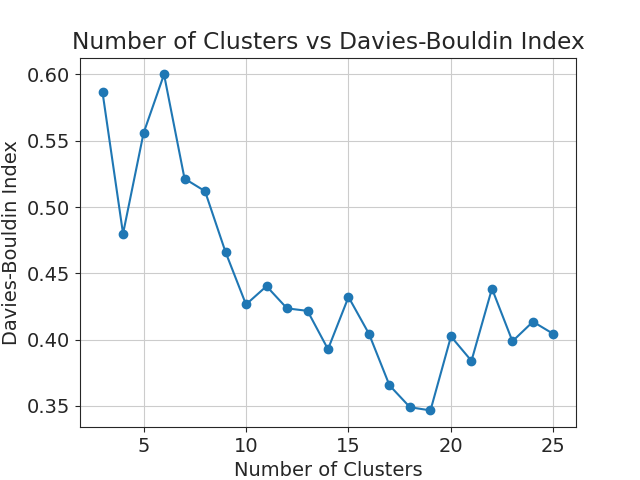

In [8]:
import src.plot_som_results as plot
from IPython.display import Image, display

# Load cluster dictionary
loaded_cluster_list = plot.load_cluster_dictionary(args.output_folder)
# Plot and save the Davies-Bouldin Index vs Number of Clusters
plot.plot_davies_bouldin(loaded_cluster_list, args.output_folder)

display(Image(filename=args.output_folder+'db_score.png'))

<p style="font-size:19px; text-align:left; font-weight:bold">5) Plot results.

Specify the parameters to plot the results and create figures. The Python script "plot_som_results.py" creates .png files of the results in som space, geospace and also creates boxplots.

In [9]:
import configs.argsPlot
import src.plot_som_results as plot

argsP = configs.argsPlot.Args()

argsP.outsomfile= args.output_file_somspace   # som calculation somspace output text file
argsP.som_x= args.som_x         # som x dimension
argsP.som_y= args.som_y         # som y dimension
argsP.input_file= args.input_file   # Input file(*.lrn)
argsP.dir= args.output_folder            # Input file(*.lrn) or directory where som.dictionary was safet to (/output/som.dictionary)
argsP.grid_type= 'rectangular' # grid type (square or hexa), (rectangular or hexagonal)
argsP.redraw='true'       # whether to draw all plots, or only those required for clustering (true: draw all. false:draw only for clustering).
argsP.outgeofile=args.output_file_geospace     # som geospace results txt file
argsP.dataType='grid'       # Data type (scatter or grid)
argsP.noDataValue='-9999'    # noData value

plot.run_plotting_script(argsP)

GeoSpace plots finished
SomSpace plots finshed


/opt/conda/envs/dev-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/envs/dev-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/envs/dev-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/envs/dev-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

Boxplots finished


Move figures into a sub folder, since "plot_som_results.py" does not override existing files. If the destination folder does not exist, it is created here. All file names are stored in a list that is used in the next step to show all output figures.

In [10]:
import shutil
import os
import glob

file_path = args.output_folder
file_patterns = ["geoplot_*.png", "somplot_*.png", "boxplot_*.png", "db_score.png"]
destination_path = file_path+"/plots/"


# Lists to store matching files with their corresponding destination paths
all_figs = []
all_figs_lable = []

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_path):
    os.makedirs(destination_path)
else:
    # Delete all files in the destination folder
    files_to_delete = glob.glob(os.path.join(destination_path, "*"))
    for file_to_delete in files_to_delete:
        os.remove(file_to_delete)

for file_pattern in file_patterns:
    # Use glob to get all files with the specified pattern
    matching_files = glob.glob(os.path.join(file_path, file_pattern))

    # Add matching files and their corresponding destination paths to the lists
    all_figs.extend([os.path.join(destination_path, os.path.basename(file)) for file in matching_files])
    all_figs_lable.extend([os.path.basename(file) for file in matching_files])

    # Move each matching file to the destination folder and overwrite existing files if necessary
    for source_file in matching_files:
        file_name = os.path.basename(source_file)
        destination_file_path = os.path.join(destination_path, file_name)

        # If the file already exists in the destination folder, delete it first
        if os.path.exists(destination_file_path):
            os.remove(destination_file_path)

        # Move the file to the destination folder
        shutil.move(source_file, destination_file_path)

print(all_figs)

['data/output/plots/geoplot_1.png', 'data/output/plots/geoplot_2.png', 'data/output/plots/geoplot_3.png', 'data/output/plots/geoplot_4.png', 'data/output/plots/somplot_1.png', 'data/output/plots/somplot_2.png', 'data/output/plots/somplot_3.png', 'data/output/plots/somplot_4.png', 'data/output/plots/boxplot_1.png', 'data/output/plots/boxplot_2.png', 'data/output/plots/db_score.png']


Show all figures that were produced by "plot_som_results.py" and moved into a subfolder.

Boxplot:
> x axis is Cluster ID </br>
> Z axis is original data value </br>
> legend: number of data points in each cluster </br>

In [11]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import ipyplot

# Clear Matplotlib cache
plt.close('all')

# Clear output
clear_output(wait=True)

images = all_figs
labels = all_figs_lable
tabs = [image.split('_')[-2] for image in labels]

print("List of figures:")
print(labels)
#print(tabs)

# Plot the images
#ipyplot.plot_images(images, max_images=50, img_width=250)
ipyplot.plot_class_representations(images,  labels, img_width=200, show_url=False)
ipyplot.plot_class_tabs(images, tabs, max_imgs_per_tab=50, img_width=400)

List of figures:
['geoplot_1.png', 'geoplot_2.png', 'geoplot_3.png', 'geoplot_4.png', 'somplot_1.png', 'somplot_2.png', 'somplot_3.png', 'somplot_4.png', 'boxplot_1.png', 'boxplot_2.png', 'db_score.png']
